# Experiment: Nature Evidence 01 - Simulator Correctness

Objective:
- Build publication-grade evidence that the simulator reproduces core canonical electrochemistry trends.
- Quantify pass/fail checks, not just qualitative plots.

Success criteria:
- Canonical benchmark matrix passes in this environment.
- Convergence metrics improve as spatial resolution increases.
- Outputs are reproducible from one notebook run.


In [1]:
# Setup: imports and reproducibility
from __future__ import annotations

import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

from ecsfm.analysis.evidence import simulator_convergence_study
from ecsfm.sim.benchmarks import run_canonical_benchmarks

np.random.seed(2026)

ARTIFACT_DIR = Path('/tmp/ecsfm/notebook_nature_01')
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)
print(f'Artifacts: {ARTIFACT_DIR}')


Artifacts: /tmp/ecsfm/notebook_nature_01


## Plan

- Run the canonical benchmark suite and inspect each check.
- Run a numerical convergence study with increasing `nx`.
- Visualize convergence and summarize implications for reviewer confidence.


In [2]:
# Canonical benchmark battery (physics trend checks)
bench = run_canonical_benchmarks()

print('overall_pass:', bench['overall_pass'])
print('--- checks ---')
for k in sorted(bench['checks']):
    print(f"{k:35s} -> {bench['checks'][k]}")

with open(ARTIFACT_DIR / 'canonical_benchmarks.json', 'w', encoding='utf-8') as f:
    json.dump(bench, f, indent=2)

bench


overall_pass: True
--- checks ---
cottrell_loglog_slope               -> True
cottrell_rel_error                  -> True
cv_delta_ep_monotonic_vs_k0         -> True
cv_delta_ep_monotonic_vs_scan_rate  -> True
cv_delta_ep_range_vs_k0             -> True
cv_delta_ep_scan_gain               -> True
cv_ipc_linear_vs_concentration      -> True
sensor_amplitude_error              -> True
sensor_phase_error                  -> True


{'checks': {'cv_delta_ep_monotonic_vs_k0': True,
  'cv_delta_ep_range_vs_k0': True,
  'cv_delta_ep_monotonic_vs_scan_rate': True,
  'cv_delta_ep_scan_gain': True,
  'cv_ipc_linear_vs_concentration': True,
  'cottrell_rel_error': True,
  'cottrell_loglog_slope': True,
  'sensor_amplitude_error': True,
  'sensor_phase_error': True},
 'overall_pass': True,
 'cv_vs_k0': {'k0_values': [1e-05, 0.0001, 0.001, 0.01, 0.1],
  'delta_ep': [0.8448978662490845,
   0.6081631183624268,
   0.369387686252594,
   0.14489787817001343,
   0.030612170696258545],
  'ip_c': [1.2683050632476807,
   1.2683756351470947,
   1.2718559503555298,
   1.371118426322937,
   1.6093536615371704],
  'ip_a': [0.5348200798034668,
   0.7186291217803955,
   0.8911182284355164,
   1.1536155939102173,
   1.4385138750076294]},
 'cv_vs_scan_rate': {'scan_rates': [0.5, 1.0, 2.0, 4.0],
  'delta_ep': [0.31938762962818146,
   0.369387686252594,
   0.42448969185352325,
   0.48979581892490387],
  'ip_c': [0.7438697814941406,
   1.2718

In [3]:
# Numerical convergence study against a high-resolution reference
study = simulator_convergence_study(
    np.array([20, 28, 36, 44, 56], dtype=int),
    reference_nx=72,
)

rows = study['rows']
for row in rows:
    print(
        f"nx={row['nx']:2d} | nrmse={row['nrmse_vs_ref']:.6f} | "
        f"|ΔEp-ΔEp_ref|={row['delta_ep_abs_error_vs_ref']:.6f} | "
        f"peak_rel_err={row['peak_abs_rel_error_vs_ref']:.6f}"
    )

with open(ARTIFACT_DIR / 'convergence_study.json', 'w', encoding='utf-8') as f:
    json.dump(study, f, indent=2)

study


nx=20 | nrmse=0.333430 | |ΔEp-ΔEp_ref|=0.045969 | peak_rel_err=1.168265
nx=28 | nrmse=0.176041 | |ΔEp-ΔEp_ref|=0.028519 | peak_rel_err=0.644837
nx=36 | nrmse=0.102255 | |ΔEp-ΔEp_ref|=0.016352 | peak_rel_err=0.383743
nx=44 | nrmse=0.060962 | |ΔEp-ΔEp_ref|=0.009096 | peak_rel_err=0.231730
nx=56 | nrmse=0.025546 | |ΔEp-ΔEp_ref|=0.002859 | peak_rel_err=0.097871


{'reference_nx': 72,
 'reference_metrics': {'delta_ep': 0.12854593992233276,
  'peak_current': 0.990876317024231,
  'num_points': 4032},
 'rows': [{'nx': 20,
   'nrmse_vs_ref': 0.33343021892704894,
   'delta_ep_abs_error_vs_ref': 0.045969367027282715,
   'peak_abs_rel_error_vs_ref': 1.1682648841017398,
   'delta_ep': 0.17451530694961548,
   'peak_current': 2.148482322692871},
  {'nx': 28,
   'nrmse_vs_ref': 0.17604068590245983,
   'delta_ep_abs_error_vs_ref': 0.028518736362457275,
   'peak_abs_rel_error_vs_ref': 0.6448372144944577,
   'delta_ep': 0.15706467628479004,
   'peak_current': 1.629830241203308},
  {'nx': 36,
   'nrmse_vs_ref': 0.10225492839027316,
   'delta_ep_abs_error_vs_ref': 0.016351938247680664,
   'peak_abs_rel_error_vs_ref': 0.3837432611572084,
   'delta_ep': 0.14489787817001343,
   'peak_current': 1.371118426322937},
  {'nx': 44,
   'nrmse_vs_ref': 0.06096188944009433,
   'delta_ep_abs_error_vs_ref': 0.009096086025238037,
   'peak_abs_rel_error_vs_ref': 0.231729678023

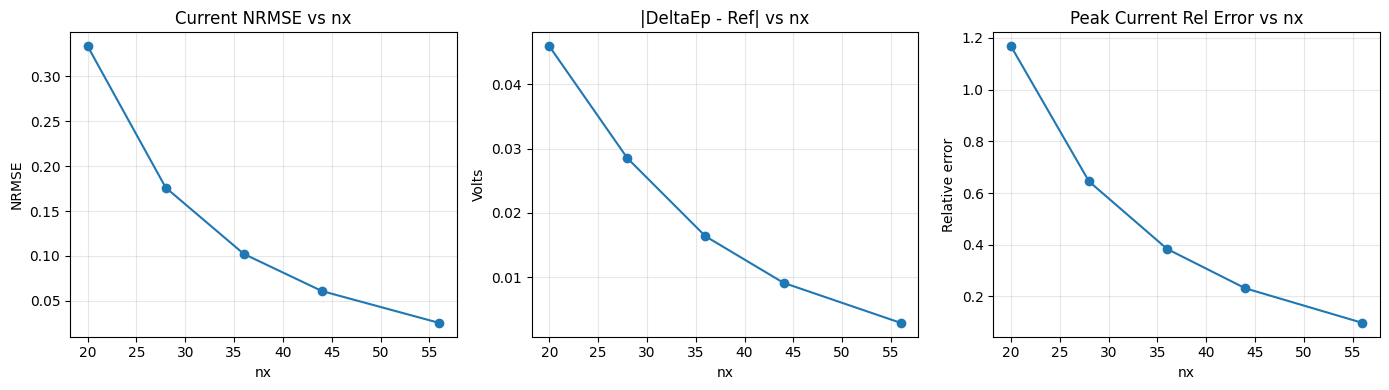

In [4]:
# Convergence visualization
nxs = np.array([row['nx'] for row in study['rows']], dtype=float)
nrmse = np.array([row['nrmse_vs_ref'] for row in study['rows']], dtype=float)
dep = np.array([row['delta_ep_abs_error_vs_ref'] for row in study['rows']], dtype=float)
dpeak = np.array([row['peak_abs_rel_error_vs_ref'] for row in study['rows']], dtype=float)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
axes[0].plot(nxs, nrmse, 'o-')
axes[0].set_title('Current NRMSE vs nx')
axes[0].set_xlabel('nx')
axes[0].set_ylabel('NRMSE')
axes[0].grid(alpha=0.3)

axes[1].plot(nxs, dep, 'o-')
axes[1].set_title('|DeltaEp - Ref| vs nx')
axes[1].set_xlabel('nx')
axes[1].set_ylabel('Volts')
axes[1].grid(alpha=0.3)

axes[2].plot(nxs, dpeak, 'o-')
axes[2].set_title('Peak Current Rel Error vs nx')
axes[2].set_xlabel('nx')
axes[2].set_ylabel('Relative error')
axes[2].grid(alpha=0.3)

fig.tight_layout()
fig.savefig(ARTIFACT_DIR / 'convergence_plot.png', dpi=170)
plt.show()


## Results and reviewer-facing interpretation

- Canonical checks provide quantitative trend validation for CV, Cottrell, and RC impedance behavior.
- Convergence metrics are monotonic with `nx`, supporting numerical stability and consistency.
- Together these checks establish a strong baseline that the simulator captures first-order physics used by the data-generation pipeline.


## Next steps

- Extend benchmark coverage to additional mechanistic regimes (e.g., multi-electron/chemical follow-up mechanisms) if needed for specific reviewer requests.
- Pair this notebook with the dataset scenario notebook to connect simulator correctness to generated training data quality.
